# Temporal Difference (TD) Methods

the root of this is to measure the value of the next state against the current value and reward



# TD Prediction

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

we will use the frozen lake env in gym to play with this algo

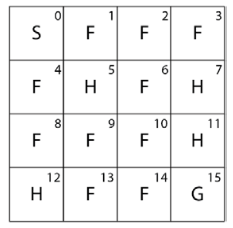

In [1]:
import gym
import pandas as pd


In [2]:
env = gym.make('FrozenLake-v1')

In [3]:
print(env.reset())

(0, {'prob': 1})


In [4]:
#define random policy for the prediction
def random_policy(env):
    return env.action_space.sample()

In [5]:
#function to run some experiments
def experimental_run(env, policy, alpha, gamma, n_episodes = 50000, n_timesteps = 1000):
    """
    simple function to run experiments
    """
    #set up value tracking object
    V = {}
    for s in range(env.observation_space.n):
        V[s]=0.0
        
    for i in range(n_episodes):
        state = env.reset()[0]
        
        for t in range(n_timesteps):
            a = random_policy(env)
            next_state, reward, done, info, other = env.step(a)
            
            V[state] += alpha * (reward + gamma * V[next_state] - V[state])
            
            state = next_state
            
            if done:
                break
    
    return pd.DataFrame(list(V.items()), columns=['state', 'value'])
    

In [6]:
df = (experimental_run(env = env, 
                       policy = random_policy, 
                       alpha = 0.85, 
                       gamma = 0.95, 
                       n_episodes = 50000, 
                       n_timesteps = 1000))

df
      

,state,value
0,0,0.003869
1,1,0.000607
2,2,0.011072
3,3,0.001203
4,4,0.003831
5,5,0.000000
6,6,0.029340
7,7,0.000000
8,8,0.005431
9,9,0.000797


the value from state 14 is high since we need to hit that state to land in the goal!

# TD Control SARSA

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

turns into state and action with:

Q(𝑠, a) = Q(𝑠, a) + 𝛼(𝑟 + 𝛾Q(𝑠', a') − Q(𝑠, a))

this is the sarsa on-policy control algorithm

we will use the frozen lake env in gym to play with this algo

and of course to balance explore and exploit an epsilon greedy selection of optimal actions

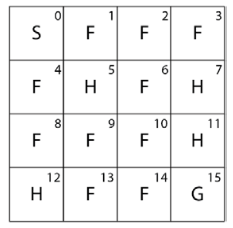

In [7]:
import gym
import pandas as pd
import numpy as np

In [8]:
env = gym.make('FrozenLake-v1')

In [9]:
print(env.reset())

(0, {'prob': 1})


In [10]:
def epsilon_greedy(state, epsilon, Q, env):
    if np.random.uniform(0,1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])
    

In [11]:
def experimental_sarsa_run(env, policy, alpha, gamma, epsilon, n_episodes = 50000, n_timesteps = 1000):
    """
    simple function to run an experiment
    """
    #init Q to all zeros
    Q = {}
    temp = [0 for a in range(env.action_space.n)]
    for s in range(env.observation_space.n):
        Q[s] = temp.copy()
        
    for i in range(n_episodes):
        state = env.reset()[0]
        
        action = policy(state, epsilon, Q, env)
        
        for t in range(n_timesteps):
            
            next_state, reward, done, info, other = env.step(action)
            
            next_action = policy(next_state, epsilon, Q, env)
            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] -  Q[state][action])
            
            state = next_state
            action = next_action
            
            if done:
                break
                
    return pd.DataFrame(list(Q.items()), columns=['state', 'action_values']), Q                                  
                                         

In [12]:
df, sarsa_q = (experimental_sarsa_run(env = env, 
                               policy = epsilon_greedy, 
                               alpha = 0.85, 
                               gamma = 0.95, 
                               epsilon = 0.10,
                               n_episodes = 50000, 
                               n_timesteps = 1000))

df
      

,state,action_values
0,0,"[0.0034631457012730647, 0.04242480507248096, 0..."
1,1,"[0.00011546385874783619, 0.008397239861203942,..."
2,2,"[0.011043336664568765, 0.000667567136585734, 0..."
3,3,"[0.0003432877656202504, 2.590458483145414e-05,..."
4,4,"[0.052466612519200505, 0.00041341955927703435,..."
5,5,"[0, 0, 0, 0]"
6,6,"[0.08580571378715757, 1.0447379354972171e-10, ..."
7,7,"[0, 0, 0, 0]"
8,8,"[0.0014497624932779986, 0.0002870444658601334,..."
9,9,"[0.051938485895356934, 0.4201478366136867, 0.0..."


# TD Control Q-learning

𝑉(𝑠) = 𝑉(𝑠) + 𝛼(𝑟 + 𝛾𝑉(𝑠′) − 𝑉(𝑠))

turns into state and action with:

Q(𝑠, a) = Q(𝑠, a) + 𝛼(𝑟 + 𝛾 max[Q(𝑠', a')] − Q(𝑠, a))

this is the q-learing off-policy control algorithm

we will use the frozen lake env in gym to play with this algo

and of course to balance explore and exploit an epsilon greedy selection of optimal actions

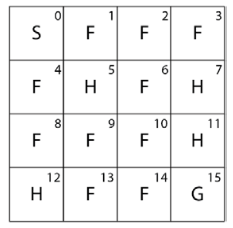

In [13]:
def experimental_q_run(env, policy, alpha, gamma, epsilon, n_episodes = 50000, n_timesteps = 1000):
    """
    simple function to run an experiment
    """
    #init Q to all zeros
    Q = {}
    temp = [0 for a in range(env.action_space.n)]
    for s in range(env.observation_space.n):
        Q[s] = temp.copy()
        
    for i in range(n_episodes):
        state = env.reset()[0]
        
        for t in range(n_timesteps):
            
            action = policy(state, epsilon, Q, env)
            
            next_state, reward, done, info, other = env.step(action)            
                        
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) -  Q[state][action])
            
            state = next_state
            
            if done:
                break
                
    return pd.DataFrame(list(Q.items()), columns=['state', 'action_values']), Q                                  
                                         

In [14]:
df, q_q = (experimental_q_run(env = env, 
                               policy = epsilon_greedy, 
                               alpha = 0.85, 
                               gamma = 0.95, 
                               epsilon = 0.10,
                               n_episodes = 50000, 
                               n_timesteps = 1000))

df
      

,state,action_values
0,0,"[0.1811186351330287, 0.46250030945049025, 0.18..."
1,1,"[0.028610439231904622, 0.027169014103587297, 0..."
2,2,"[0.06825949498743189, 0.1532784671701508, 0.12..."
3,3,"[0.0338590952482789, 0.023599248124347855, 0.0..."
4,4,"[0.587779375764371, 0.048749606444288995, 0.03..."
5,5,"[0, 0, 0, 0]"
6,6,"[0.005933455664768765, 4.999721387400572e-05, ..."
7,7,"[0, 0, 0, 0]"
8,8,"[0.31466441414357893, 0.06478825039513686, 0.0..."
9,9,"[0.0010760956660953933, 0.618961303589265, 0.0..."


# comparison of output q tables

create a function to run thru the frozen lake env and show outcomes over 1000 episodes using the supplied q objects using a purely greedy policy


In [17]:
import matplotlib.pyplot as plt

def greedy_policy(q, state):
    return np.argmax(q[state])

def run_episode(q, policy, env):
    done = 0
    total_reward = 0
    state = env.reset()[0]
    while not done:
        action = policy(q, state)
        state, reward, done, info, other = env.step(action)
        total_reward += reward 
        
    return total_reward

def compare_q(env, q_q, sarsa_q, policy, n_episodes = 1000):
    q_scores = []
    sarsa_scores = []
    
    for i in range(n_episodes):
        q_scores.append(run_episode(q_q, policy, env))
        sarsa_scores.append(run_episode(sarsa_q, policy, env))
        
    
    #plot scores
    print("avg q score :", np.mean(q_scores))
    print("avg sarsa score :", np.mean(sarsa_scores))
    
    plt.plot(q_scores, label = 'q scores')
    plt.plot(sarsa_scores, label = 'sarsa scores')  
    plt.title('score over experiment runs')
    plt.legend()
    plt.show()    

avg q score : 0.813
avg sarsa score : 0.248


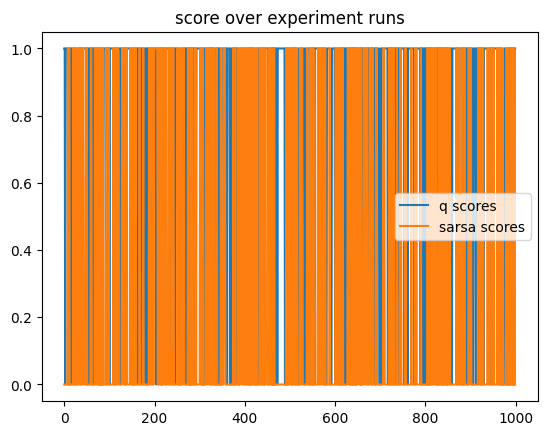

In [16]:
compare_q(env, q_q, sarsa_q, greedy_policy, n_episodes = 1000)

scores can fluctuate wildly in a random markov chain env like frozen lake!

generally q learning does better long term with learning in this environment given the better overall score.